In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import pandas_datareader.data as web
from time import sleep
import quandl
import seaborn as sns
import sys
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import urllib
from datetime import date , timedelta

import requests
import json
import re

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def calc_bond_returns(YTM, YTMM1, M):
    DY = YTM - YTMM1
    yield_income = (1+YTM)**(1/12) - 1
    Z = (1+(YTM/2))
    

    duration = (1/YTM)* (1 -(1/(1+0.5*YTM)**(2*M)))


    C1 = (2/YTM**2) * (1-Z**(-2*M))
    C2 = ((2*M)/YTM) * Z **(-2*M - 1) 
    convex = C1-C2

    ret = yield_income - duration* DY + (1/2)*convex * (DY**2)
    return(ret)



def monthly_bonds_ret(bond_YTM, M):
    bond_ret = [0]

   
    
    for i in range(len(bond_YTM)-1):
        YTM = bond_YTM[i+1]
        YTMM1 = bond_YTM[i]
        
        ret = calc_bond_returns(YTM, YTMM1, M)
        bond_ret.append(ret)

    bond_ret = pd.DataFrame(bond_ret)
    #bond_ret.index = bond_YTM.index + pd.Timedelta('1 day')
    bond_ret.index = bond_YTM.index
    
    bond_ret = (bond_ret+1).cumprod()
    return(bond_ret)

# Analyzing future 1 month return based on macro ROC

- start with IP ROC and CPI ROC
- then combine
- ROC Rates

In [9]:
diff = 12
horizon = 1

In [10]:
GDP_tmp = web.DataReader('GDPC1','fred', '1970-01-01') #Quaterly
CPI_tmp = web.DataReader('CPIAUCSL','fred', '1970-01-01') # Monthly
yield10_tmp = web.DataReader('DGS10','fred', '1970-01-01') # Daily
M2_tmp = web.DataReader('M2','fred', '1970-01-01') # Weekly
yield2_tmp = web.DataReader('DGS2','fred', '1970-01-01') # Daily
IP_tmp =  web.DataReader('INDPRO','fred', '1970-01-01') #monthly
yiedl_10_2_tmp = web.DataReader('T10Y2Y','fred', '1970-01-01')# Daily
HY_spread_tmp = web.DataReader('BAMLH0A0HYM2','fred', '1970-01-01') # Daily
real_rate_tmp = web.DataReader('REAINTRATREARAT10Y','fred', '1970-01-01') # Daily

In [11]:
#We want diff from 1 year ago!!

IP_RC = IP_tmp.pct_change(12).diff(diff)
CPI_RC = CPI_tmp.pct_change(12).diff(diff)
real_rate = real_rate_tmp.diff(diff)
real_rate.columns = ['real_rate']

yield2_change = yield2_tmp.resample('M').last()
yield2_change = yield2_change.diff(diff)
yiedl_10_2_change = yiedl_10_2_tmp.resample('M').last()
yiedl_10_2_change = yiedl_10_2_change.diff(diff)
HY_change = HY_spread_tmp.resample('M').last()
HY_change = HY_change.diff(diff)
HY_change.columns = ['HY_spread']

# SP500
SP500_daily_tmp = yf.download("^SP500TR")
SP500_daily= pd.DataFrame(SP500_daily_tmp['Close'])
SP500_daily.columns = ['Trend']
SP500_monthly = SP500_daily.resample('M').last()
stock_trend = SP500_monthly.pct_change(diff)

# Gold
gld_daily_tmp = yf.download("GLD")
gld_daily= pd.DataFrame(gld_daily_tmp['Close'])
gld_daily.columns = ['Gold Trend']
gld_monthly = gld_daily.resample('M').last()
gld_trend = gld_monthly.pct_change(diff)



RC_tmp = pd.concat([IP_RC, CPI_RC],axis =1)

tol = pd.Timedelta('5 day')
RC_Data = pd.merge_asof(left=RC_tmp,right=yield2_change,right_index=True,left_index=True,direction='nearest',tolerance=tol)
RC_Data.columns = ["IP", "CPI", '2 Year Yield']

RC_Data = pd.merge_asof(left=RC_Data,right=yiedl_10_2_change,right_index=True,left_index=True,direction='nearest',tolerance=tol)
RC_Data = pd.merge_asof(left=RC_Data,right=HY_change,right_index=True,left_index=True,direction='nearest',tolerance=tol)
RC_Data = pd.merge_asof(left=RC_Data,right=stock_trend,right_index=True,left_index=True,direction='nearest',tolerance=tol)
RC_Data = pd.merge_asof(left=RC_Data,right=gld_trend,right_index=True,left_index=True,direction='nearest',tolerance=tol)


RC_Data = pd.merge_asof(left=RC_Data,right=real_rate,right_index=True,left_index=True,direction='nearest',tolerance=tol)







#RC_Data = RC_Data.dropna()
RC_Data.index = RC_Data.index.to_period('M').to_timestamp('M')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
RC_Data

IP       CPI  2 Year Yield  T10Y2Y  HY_spread     Trend  \
DATE                                                                        
1970-01-31       NaN       NaN           NaN     NaN        NaN       NaN   
1970-02-28       NaN       NaN           NaN     NaN        NaN       NaN   
1970-03-31       NaN       NaN           NaN     NaN        NaN       NaN   
1970-04-30       NaN       NaN           NaN     NaN        NaN       NaN   
1970-05-31       NaN       NaN           NaN     NaN        NaN       NaN   
...              ...       ...           ...     ...        ...       ...   
2021-12-31 -0.009789  0.017066          0.32   -0.19       0.46  0.013224   
2022-01-31 -0.015972  0.012890          0.45   -0.45      -0.05  0.110271   
2022-02-28  0.024785  0.010837          0.70   -0.46       0.48 -0.016114   
2022-03-31  0.018815  0.014610          0.92   -0.52       0.10 -0.038915   
2022-04-30  0.032335  0.006982          1.55   -0.75       0.33 -0.045985   

            Gold Trend  real_rate  
DATE                               
1970-01-31         NaN        NaN  
1970-02-28         NaN        NaN  
1970-03-31         NaN        NaN  
1970-04-30         NaN        NaN  
1970-05-31         NaN        NaN  
...                ...        ...  
2021-12-31   -0.024692   0.286420  
2022-01-31    0.041043   0.231594  
2022-02-28    0.008641   0.258008  
2022-03-31    0.077825        NaN  
2022-04-30    0.056680        NaN  

[628 rows x 8 columns]

In [13]:
#RC_Data
RC_Data.loc[:, 'IP State'] = ["Increasing" if x>0 else "Decresing" for x in RC_Data['IP']]
RC_Data.loc[:, 'CPI State'] = ["Increasing" if x>0 else "Decresing" for x in RC_Data['CPI']]
RC_Data.loc[:, 'Rate State'] = ["Increasing" if x>0 else "Decresing" for x in RC_Data['2 Year Yield']]
RC_Data.loc[:, 'Real Rate State'] = ["Increasing" if x>0 else "Decresing" for x in RC_Data['real_rate']]

RC_Data.loc[:, 'Curve State'] = ["Increasing" if x>0 else "Decresing" for x in RC_Data['T10Y2Y']]
RC_Data.loc[:, 'HY State'] = ["Increasing" if x>0 else "Decresing" for x in RC_Data['HY_spread']]
RC_Data.loc[:, 'Trend'] = ["Increasing" if x>0 else "Decresing" for x in RC_Data['Trend']]

RC_Data.loc[:, 'Gold Trend'] = ["Increasing" if x>0 else "Decresing" for x in RC_Data['Gold Trend']]



RC_states = RC_Data[['IP State', 'CPI State','Rate State', 'Curve State', 'HY State', 'Trend', 'Real Rate State', 'Gold Trend']]


In [14]:
RC_states.loc[:,'quad'] = 0


RC_states.loc[(RC_states['IP State'] == 'Increasing') & (RC_states['CPI State'] == 'Decresing')
              , 'quad'] = 'Q1'
RC_states.loc[(RC_states['IP State'] == 'Increasing') & (RC_states['CPI State'] == 'Increasing')
              , 'quad'] = 'Q2'


RC_states.loc[(RC_states['IP State'] == 'Decresing') & (RC_states['CPI State'] == 'Increasing')
              , 'quad'] = 'Q3'

RC_states.loc[(RC_states['IP State'] == 'Decresing') & (RC_states['CPI State'] == 'Decresing')
              , 'quad'] = 'Q4'

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [15]:
RC_states.loc[:,'H_quad'] = 0


RC_states.loc[(RC_states['HY State'] == 'Decresing') & (RC_states['Curve State'] == 'Decresing')
              , 'H_quad'] = 'Q1'


RC_states.loc[(RC_states['HY State'] == 'Decresing') & (RC_states['Curve State'] == 'Increasing')
              , 'H_quad'] = 'Q2'


RC_states.loc[(RC_states['HY State'] == 'Increasing') & (RC_states['Curve State'] == 'Increasing')
              , 'H_quad'] = 'Q3'

RC_states.loc[(RC_states['HY State'] == 'Increasing') & (RC_states['Curve State'] == 'Decresing')
              , 'H_quad'] = 'Q4'


In [16]:
## Import Asset Data

T_Bill_tmp = yf.download('^IRX') #data import
T_Bill = T_Bill_tmp['Adj Close']
T_Bill = T_Bill.resample('M').last()/100

T_Bill = monthly_bonds_ret(T_Bill, 0.25)
T_Bill.columns = ['3 Month T-Bill']


bond_30YR_tmp = yf.download('^TYX') #data import
bond_30YR = bond_30YR_tmp['Adj Close']
bond_30YR_monthly = bond_30YR.resample('M').last()/100

Ret_bond_30YR = monthly_bonds_ret(bond_30YR_monthly, 30)
Ret_bond_30YR.columns = ['Bond 30 Yr']


bond_5YR_tmp = yf.download('^FVX') #data import
bond_5YR = bond_5YR_tmp['Adj Close']
bond_5YR_monthly = bond_5YR.resample('M').last()/100

Ret_bond_5YR = monthly_bonds_ret(bond_5YR_monthly, 5)
Ret_bond_5YR.columns = ['Bond 5 Yr']


bond_10YR_tmp = yf.download('^TNX') #data import
bond_10YR = bond_10YR_tmp['Adj Close']
bond_10YR_monthly = bond_10YR.resample('M').last()/100

Ret_bond_10YR = monthly_bonds_ret(bond_10YR_monthly, 10)
Ret_bond_10YR.columns = ['Bond 10 Yr']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
assets_tmp = pd.DataFrame()
assets = ['TLT', 'SPY' ,'GLD']
for tick in assets:
    price_tmp = yf.download(tick)
    price_tmp= pd.DataFrame(price_tmp['Adj Close'])
    price_tmp.columns = [tick]
    price_tmp = price_tmp.resample('M').last()
    assets_tmp = pd.concat([assets_tmp,price_tmp ], axis = 1)

assets.remove('SPY')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
#Forward 1 month return
return_df = assets_tmp.pct_change(horizon).shift(-horizon)
return_df = return_df[::horizon]
total_df = pd.merge(RC_states, return_df, left_index=True, right_index=True)

## Plot Returns for states


In [19]:

IP_returns_df = pd.DataFrame(total_df.groupby("IP State").mean()['SPY'])
for asset in assets:
    IP_returns_df = pd.merge(IP_returns_df, pd.DataFrame(total_df.groupby("IP State").mean()[asset]), left_index=True, right_index=True)

IP_returns_df = IP_returns_df*(12/horizon)


CPI_returns_df = pd.DataFrame(total_df.groupby("CPI State").mean()['SPY'])
for asset in assets:
    CPI_returns_df = pd.merge(CPI_returns_df, pd.DataFrame(total_df.groupby("CPI State").mean()[asset]), left_index=True, right_index=True)

CPI_returns_df = CPI_returns_df*(12/horizon)


rate_returns_df = pd.DataFrame(total_df.groupby("Rate State").mean()['SPY'])
for asset in assets:
    rate_returns_df = pd.merge(rate_returns_df, pd.DataFrame(total_df.groupby("Rate State").mean()[asset]), left_index=True, right_index=True)

rate_returns_df = rate_returns_df*(12/horizon)

real_rate_returns_df = pd.DataFrame(total_df.groupby("Real Rate State").mean()['SPY'])
for asset in assets:
    real_rate_returns_df = pd.merge(real_rate_returns_df, pd.DataFrame(total_df.groupby("Real Rate State").mean()[asset]), left_index=True, right_index=True)

real_rate_returns_df = real_rate_returns_df*(12/horizon)

curve_returns_df = pd.DataFrame(total_df.groupby("Curve State").mean()['SPY'])
for asset in assets:
    curve_returns_df = pd.merge(curve_returns_df, pd.DataFrame(total_df.groupby("Curve State").mean()[asset]), left_index=True, right_index=True)

curve_returns_df = curve_returns_df*(12/horizon)

hy_returns_df = pd.DataFrame(total_df.groupby("HY State").mean()['SPY'])
for asset in assets:
    hy_returns_df = pd.merge(hy_returns_df, pd.DataFrame(total_df.groupby("HY State").mean()[asset]), left_index=True, right_index=True)

hy_returns_df = hy_returns_df*(12/horizon)


trend_returns_df = pd.DataFrame(total_df.groupby("Trend").mean()['SPY'])
for asset in assets:
    trend_returns_df = pd.merge(trend_returns_df, pd.DataFrame(total_df.groupby("Trend").mean()[asset]), left_index=True, right_index=True)

trend_returns_df = trend_returns_df*(12/horizon)


gold_trend_returns_df = pd.DataFrame(total_df.groupby("Gold Trend").mean()['SPY'])
for asset in assets:
    gold_trend_returns_df = pd.merge(gold_trend_returns_df, pd.DataFrame(total_df.groupby("Gold Trend").mean()[asset]), left_index=True, right_index=True)

gold_trend_returns_df = gold_trend_returns_df*(12/horizon)

################

quad_returns_df = pd.DataFrame(total_df.groupby("quad").mean()['SPY'])
for asset in assets:
    quad_returns_df = pd.merge(quad_returns_df, pd.DataFrame(total_df.groupby("quad").mean()[asset]), left_index=True, right_index=True)

quad_returns_df = quad_returns_df*(12/horizon)



h_quad_returns_df = pd.DataFrame(total_df.groupby("H_quad").mean()['SPY'])
for asset in assets:
    h_quad_returns_df = pd.merge(h_quad_returns_df, pd.DataFrame(total_df.groupby("H_quad").mean()[asset]), left_index=True, right_index=True)

h_quad_returns_df = h_quad_returns_df*(12/horizon)


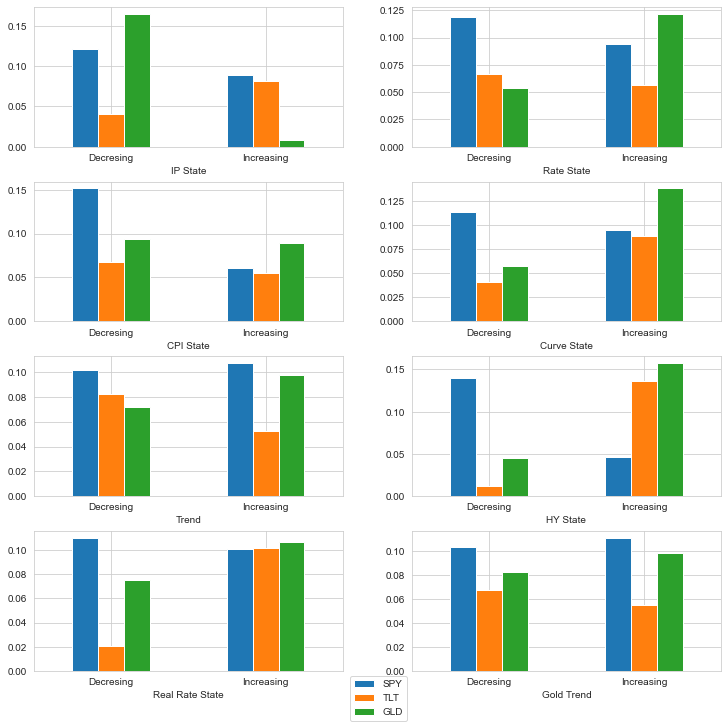

In [20]:
#fig, ax = plt.subplots(2,3, sharex=True, sharey = True)
#fig.suptitle('Momentum measures and 1 month forward returns', fontsize=18, y=1)
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=4,ncols=2,constrained_layout=True)
#fig.suptitle('Returns based on Macro Fundamentals', fontsize=20, y=1)
IP_returns_df.plot.bar(rot=0,ax = axes[0,0], legend=False,figsize=(10,10)) 

CPI_returns_df.plot.bar(rot=0,ax = axes[1, 0], legend=False)
rate_returns_df.plot.bar(rot=0,ax = axes[0,1], legend=False) 
curve_returns_df.plot.bar(rot=0,ax = axes[1,1], legend=False)
hy_returns_df.plot.bar(rot=0,ax = axes[2,1], legend=False)
trend_returns_df.plot.bar(rot=0,ax = axes[2,0], legend=False)
real_rate_returns_df.plot.bar(rot=0,ax = axes[3,0], legend=False)
gold_trend_returns_df.plot.bar(rot=0,ax = axes[3,1], legend=False)

plt.legend(curve_returns_df.columns.values,bbox_to_anchor=(0, 0));


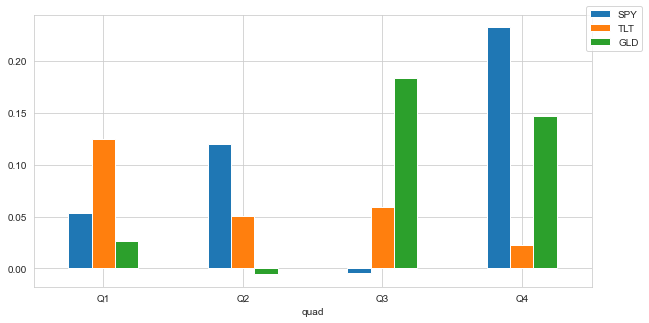

In [26]:
quad_returns_df.plot.bar(rot=0,figsize=(10,5));
plt.legend(curve_returns_df.columns.values,bbox_to_anchor=(1.1, 1.05));

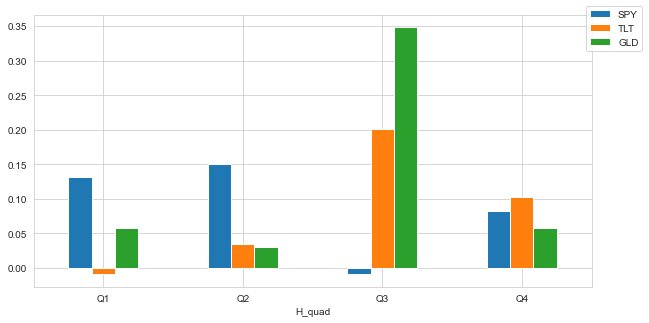

In [27]:
h_quad_returns_df.plot.bar(rot=0,figsize=(10,5));
plt.legend(curve_returns_df.columns.values,bbox_to_anchor=(1.1, 1.05));

In [23]:
#correlation of macro indicators

corr_df = total_df[['IP State', 'CPI State','Rate State','Real Rate State','Curve State', 'HY State','Trend', "Gold Trend"]]

for col in corr_df.columns:
    corr_df.loc[:,col] = corr_df[col].astype('category').cat.codes
    

corr_df.corr(method = 'spearman' )

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


IP State  CPI State  Rate State  Real Rate State  \
IP State         1.000000   0.074013    0.200340         0.170026   
CPI State        0.074013   1.000000    0.136254         0.142214   
Rate State       0.200340   0.136254    1.000000         0.610072   
Real Rate State  0.170026   0.142214    0.610072         1.000000   
Curve State     -0.107751   0.133608   -0.181677         0.042209   
HY State        -0.190024  -0.093006   -0.222096        -0.237362   
Trend            0.132259   0.124315    0.152547         0.170419   
Gold Trend       0.010470   0.097573   -0.102940        -0.109188   

                 Curve State  HY State     Trend  Gold Trend  
IP State           -0.107751 -0.190024  0.132259    0.010470  
CPI State           0.133608 -0.093006  0.124315    0.097573  
Rate State         -0.181677 -0.222096  0.152547   -0.102940  
Real Rate State     0.042209 -0.237362  0.170419   -0.109188  
Curve State         1.000000 -0.032133 -0.022805   -0.026557  
HY State           -0.032133  1.000000 -0.463444    0.079013  
Trend              -0.022805 -0.463444  1.000000   -0.022172  
Gold Trend         -0.026557  0.079013 -0.022172    1.000000

In [24]:
sum(RC_states['H_quad'] == 'Q1')/len(RC_states)

0.49203821656050956

In [28]:
RC_states.tail(15)

IP State   CPI State  Rate State Curve State    HY State  \
DATE                                                                     
2021-02-28   Decresing  Increasing   Decresing  Increasing   Decresing   
2021-03-31  Increasing  Increasing   Decresing  Increasing   Decresing   
2021-04-30  Increasing  Increasing  Increasing  Increasing   Decresing   
2021-05-31  Increasing  Increasing  Increasing  Increasing   Decresing   
2021-06-30  Increasing  Increasing   Decresing  Increasing   Decresing   
2021-07-31   Decresing  Increasing  Increasing   Decresing   Decresing   
2021-08-31   Decresing  Increasing  Increasing   Decresing  Increasing   
2021-09-30   Decresing  Increasing  Increasing   Decresing   Decresing   
2021-10-31   Decresing  Increasing  Increasing  Increasing  Increasing   
2021-11-30   Decresing  Increasing  Increasing  Increasing   Decresing   
2021-12-31   Decresing  Increasing  Increasing   Decresing  Increasing   
2022-01-31   Decresing  Increasing  Increasing   Decresing   Decresing   
2022-02-28  Increasing  Increasing  Increasing   Decresing  Increasing   
2022-03-31  Increasing  Increasing  Increasing   Decresing  Increasing   
2022-04-30  Increasing  Increasing  Increasing   Decresing  Increasing   

                 Trend Real Rate State  Gold Trend quad H_quad  
DATE                                                            
2021-02-28  Increasing       Decresing   Decresing   Q3     Q2  
2021-03-31  Increasing      Increasing   Decresing   Q2     Q2  
2021-04-30  Increasing      Increasing   Decresing   Q2     Q2  
2021-05-31  Increasing      Increasing   Decresing   Q2     Q2  
2021-06-30  Increasing       Decresing  Increasing   Q2     Q2  
2021-07-31  Increasing       Decresing  Increasing   Q3     Q1  
2021-08-31  Increasing       Decresing  Increasing   Q3     Q4  
2021-09-30  Increasing       Decresing   Decresing   Q3     Q1  
2021-10-31  Increasing      Increasing   Decresing   Q3     Q3  
2021-11-30  Increasing      Increasing   Decresing   Q3     Q2  
2021-12-31  Increasing      Increasing   Decresing   Q3     Q4  
2022-01-31  Increasing      Increasing  Increasing   Q3     Q1  
2022-02-28   Decresing      Increasing  Increasing   Q2     Q4  
2022-03-31   Decresing       Decresing  Increasing   Q2     Q4  
2022-04-30   Decresing       Decresing  Increasing   Q2     Q4

## Get OECD Data
-  calculate global average
- Economic activity and Inflation
- calculate avergae over multiple countries, so get a probability and table!!!

https://grzegorz.link/growth


In [34]:
import pandas_datareader.data as web
import pandas_datareader
import requests_cache


CLI_api = pandas_datareader.oecd.OECDReader(symbols = 'MEI_CLI',timeout=30000, retry_count=5)
CLI_api.start = date(1960, 1,1)

In [35]:
CLI_read = CLI_api.read()

In [36]:
CLI_df = CLI_read.iloc[:, CLI_read.columns.get_level_values(0)=='Amplitude adjusted (CLI)']
CLI_df = CLI_df.iloc[:, CLI_df.columns.get_level_values(2) == 'Monthly']

CLI_df.columns = CLI_df.columns.droplevel(0)
CLI_df.columns = CLI_df.columns.droplevel(1)

In [37]:
#CLI_df.columns

In [38]:
#CLI_df['Sweden'].dropna().diff(1).plot();
#CLI_df['Sweden'].diff(1).tail(20)

In [42]:
## MAKE NICE DASHBOARD

CLI_df[['Sweden','United States','OECD - Europe', 'OECD - Total']].diff(1).tail(12).transpose()


Time           2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  \
Country                                                                     
Sweden            0.17921     0.34237     0.45962     0.52389     0.51070   
United States     0.22223     0.40100     0.50863     0.55371     0.55874   
OECD - Europe     0.49729     0.64861     0.71963     0.72907     0.69434   
OECD - Total      0.36394     0.52306     0.61065     0.63581     0.61637   

Time           2020-11-01  2020-12-01  2021-01-01  2021-02-01  2021-03-01  \
Country                                                                     
Sweden            0.48664     0.46335     0.44565     0.43305     0.42025   
United States     0.53400     0.49311     0.45223     0.41570     0.35955   
OECD - Europe     0.62905     0.53218     0.42209     0.31579     0.22830   
OECD - Total      0.56434     0.48751     0.40707     0.33340     0.26436   

Time           ...  2021-08-01  2021-09-01  2021-10-01  2021-11-01  \
Country        ...                                                   
Sweden         ...     0.29720     0.22440     0.14880     0.08640   
United States  ...    -0.07663    -0.06592    -0.00342     0.07065   
OECD - Europe  ...     0.06460     0.09050     0.12130     0.13610   
OECD - Total   ...    -0.00010     0.01160     0.04760     0.08300   

Time           2021-12-01  2022-01-01  2022-02-01  2022-03-01  2022-04-01  \
Country                                                                     
Sweden            0.01780    -0.02780     -0.0611     -0.0750     -0.1028   
United States     0.12973     0.18131      0.1926      0.1612      0.0933   
OECD - Europe     0.13510     0.12070      0.0935      0.0485     -0.0190   
OECD - Total      0.10800     0.12470      0.1167      0.0822      0.0188   

Time           2022-05-01  
Country                    
Sweden            -0.1348  
United States     -0.0110  
OECD - Europe     -0.0866  
OECD - Total      -0.0585  

[4 rows x 24 columns]

## CPI

In [40]:
test = pandas_datareader.oecd.OECDReader(symbols = 'PRICES_CPI',timeout=30000, retry_count=10)
tmp_api = test.read()

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [43]:
tmp_2 = tmp_api.iloc[:, tmp_api.columns.get_level_values(1)=='CPI: 01-12 - All items']
tmp_2 = tmp_2.iloc[:, tmp_2.columns.get_level_values(3) == 'Annual']
#tmp_2 = tmp_2.iloc[:, tmp_2.columns.get_level_values(2) == 'Percentage change on the same period of the previous year']
tmp_2 = tmp_2.iloc[:, tmp_2.columns.get_level_values(2) == 'Index, s.a']

tmp_2.columns = tmp_2.columns.droplevel(1)
tmp_2.columns = tmp_2.columns.droplevel(1)
tmp_2.columns = tmp_2.columns.droplevel(1)